In [1]:
import tensorflow as tf
from model import SimpleModel as Model
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
os.listdir('model')

['trn_site-seed1_trn_test_site-seed1_test_mlp_layer-8-8_embedding_size-4_weights-9_option-weighted_loss',
 'trn_site-seed1_trn_test_site-seed1_test_mlp_layer-8-8-8_embedding_size-8_weights-10_option-weighted_loss',
 'embedding_size-8_mlp_layer-16-16-8_option-test_test_site-seed1_test_trn_site-seed1_trn',
 'embedding_size-3_mlp_layer-8-8_option-sep_mlp_test_site-seed1_test_trn_site-seed1_trn',
 "embedding_size-3_mlp_layer-['8', '8']_option-None_test_site-seed1_test_trn_site-seed1_trn"]

In [8]:
model_dir = 'trn_site-seed1_trn_test_site-seed1_test_mlp_layer-8-8-8_embedding_size-8_weights-9_option-weighted_loss'
# model_dir = 'keep_prob-1.0_output_layer-64_64_rnn_cell-gru_rnn_layer-64_64_share_encoder-True_test_site-Site_24_trn_site-Site_1'
# model_dir = 'keep_prob-1.0_output_layer-64_64_rnn_cell-gru_rnn_layer-64_64_share_encoder-False_test_site-Site_1_trn_site-Site_23'

In [9]:
trn_site = re.search('trn_site-([A-Za-z]+\d+_trn)', model_dir).group(1)
test_site = re.search('test_site-([A-Za-z]+\d+_test)', model_dir).group(1)
mlp_layer = [int(x) for x in re.search('mlp_layer((-\d)+)_', model_dir).group(1).split('-')[1:]]
embedding_size = int(re.search('embedding_size-(\d+)', model_dir).group(1))
weights = int(re.search('weights-(\d+)', model_dir).group(1))
vocab_size = 6

In [10]:
model_config = {'trn_site': trn_site,
                'test_site': test_site,
                }

In [13]:
def get_inputs(data_type):
    data = np.load('data/{}/data.npz'.format(data_type))    
    if 'trn' in data_type:
        idx = np.load('data/{}/idx_permute.npz'.format(data_type))    
    else:
        idx = None
#     data['float_vars']
#     data['int_vars']
#     data['target_vars']
    return data, idx

In [15]:
trn, idx_list = get_inputs(trn_site)

In [16]:
test, _ = get_inputs(test_site)

In [58]:
tf.reset_default_graph()

In [17]:
float_inputs = tf.placeholder(tf.float32, [None, 8])
int_inputs = tf.placeholder(tf.int32, [None])
targets = tf.placeholder(tf.float32, [None, 2])

In [60]:
trn['float_vars'].shape

(1759804, 8)

In [18]:
data_inputs = {'float_vars' : float_inputs,
               'int_vars' : int_inputs,
               'target_vars' : targets}

In [62]:
with tf.variable_scope('Model'):
    with tf.name_scope('Train'):            
        model = Model(data_inputs, mlp_layer, vocab_size=vocab_size, embedding_size=embedding_size,
                     f)

In [63]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [64]:
saver = tf.train.Saver()

In [119]:
latest_ckpt = tf.train.latest_checkpoint('model/{}'.format(model_dir))

In [122]:
latest_ckpt

'model/embedding_size-4_mlp_layer-8-8_option-None_test_site-seed0_test_trn_site-seed0_trn/model_l.ckpt-17'

In [123]:
os.listdir('model/'+model_dir)

['model_l.ckpt-11.data-00000-of-00001',
 'model_l.ckpt-12.data-00000-of-00001',
 'model_l.ckpt-12.meta',
 'model_l.ckpt-30.data-00000-of-00001',
 'model_l.ckpt-17.index',
 'model_l.ckpt-9.data-00000-of-00001',
 'checkpoint',
 'model_l.ckpt-11.index',
 'model_l.ckpt-14.meta',
 'model_l.ckpt-29.meta',
 'model_l.ckpt-32.index',
 'model_l.ckpt-32.meta',
 'model_l.ckpt-17.data-00000-of-00001',
 'model_l.ckpt-31.meta',
 'model_l.ckpt-29.index',
 'model_l.ckpt-9.index',
 'model_l.ckpt-15.meta',
 'model_l.ckpt-14.data-00000-of-00001',
 'model_l.ckpt-11.meta',
 'model_l.ckpt-29.data-00000-of-00001',
 'model_l.ckpt-15.index',
 'model_l.ckpt-31.index',
 'model_l.ckpt-30.meta',
 'model_l.ckpt-30.index',
 'model_l.ckpt-9.meta',
 'model_l.ckpt-31.data-00000-of-00001',
 'model_l.ckpt-15.data-00000-of-00001',
 'model_l.ckpt-32.data-00000-of-00001',
 'model_l.ckpt-12.index',
 'model_l.ckpt-14.index',
 'model_l.ckpt-17.meta']

In [67]:
latest_ckpt

'model/embedding_size-4_mlp_layer-8-8_option-None_test_site-seed0_test_trn_site-seed0_trn/model_l.ckpt-9'

In [68]:
saver.restore(sess, latest_ckpt)

INFO:tensorflow:Restoring parameters from model/embedding_size-4_mlp_layer-8-8_option-None_test_site-seed0_test_trn_site-seed0_trn/model_l.ckpt-9


In [87]:
import pandas as pd

In [92]:
def error_per_mode(pred, target, mode):
    mode = np.squeeze(mode)
    mode_var = ['off_mode', 'cool_off', 'heat_off', "blowing", 'cool_on',
                'heat_on', 'heat_on']    
    error_dict = dict()
    error_values_dict = dict()
    error = pred - target
    for i in np.unique(mode):
        tmp = error[np.where(mode == i)]        
        error_dict[mode_var[i]] = (np.mean(np.abs(tmp)), np.std(np.abs(tmp)))
        error_values_dict[mode_var[i]] = tmp
    
    df = pd.DataFrame(columns=['pred', 'target', 'error', 'mape', 'mode'])
    df['mode'] = mode
    df['pred'] = pred
    df['target'] = target
    df['error'] = error
    df['mape'] = np.abs(error / target)    
    return error_dict, error_values_dict, df

In [93]:
def report(data):
    pred_s = sess.run(model.pred_s, feed_dict={float_inputs : data['float_vars'],
                                           int_inputs : np.squeeze(data['int_vars']),
                                           targets : data['target_vars']})
    error_s, error_value_s, df_s = error_per_mode(pred_s, data['target_vars'][:,0], data['int_vars'])
    
    pred_l = sess.run(model.pred_l, feed_dict={float_inputs : data['float_vars'],
                                           int_inputs : np.squeeze(data['int_vars']),
                                           targets : data['target_vars']})
    error_l, error_value_l, df_l = error_per_mode(pred_l, data['target_vars'][:,1], data['int_vars'])    
    print('error_s')
    for k, v in error_s.items():
        print(k, v)
    print('error_l')
    for k, v in error_l.items():
        print(k, v)
    return error_s, error_value_s, error_l, error_value_l, df_s, df_l

In [101]:
error_s, error_value_s, error_l, error_value_l, df_s_trn, df_l_trn = report(trn)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


error_s
off_mode (0.0019830042535668095, 0.0052176113336079239)
cool_off (0.010984244809763712, 0.012337530256050147)
heat_off (0.012224827561680446, 0.019189342236743373)
blowing (0.014295921544200296, 0.017523567461154885)
cool_on (0.013314102564330185, 0.013950843305688231)
heat_on (0.021978909885620488, 0.027827558047019488)
error_l
off_mode (0.00038485437607853031, 0.00098779964770082411)
cool_off (0.0052581178688090443, 0.0076325957491450063)
heat_off (0.0011679916470272215, 0.0014487064597315117)
blowing (0.0012025970801173619, 0.0028854043848046524)
cool_on (0.0059128219411983948, 0.007516744887804616)
heat_on (0.00090718158525830846, 0.0013824203557366919)


In [102]:
error_s, error_value_s, error_l, error_value_l, df_s_test, df_l_test = report(test)

error_s
off_mode (0.0019835337213554931, 0.0050172361296700876)
cool_off (0.01104139651599449, 0.0119359852139973)
heat_off (0.011954611198542301, 0.017479022504455904)
blowing (0.010817571087654694, 0.0079700909100925647)
cool_on (0.013206942262163396, 0.014476059622860742)
heat_on (0.022129886923571596, 0.027299274674631498)
error_l
off_mode (0.00038520480825498556, 0.0009535193229498909)
cool_off (0.005439003988217706, 0.0078964331764345766)
heat_off (0.0011489770253590784, 0.0014012731292694037)
blowing (0.0012467314902448042, 0.0034732720012692155)
cool_on (0.005945755689847127, 0.0077264241910268419)
heat_on (0.00090223016726597653, 0.0013379831248751684)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


In [155]:
df_s = pd.concat([df_s_trn, df_s_test])
df_s['trn_test'] = 'Trn'

In [156]:
df_s.index = np.hstack([idx_list['trn_idx'], idx_list['test_idx']])

In [157]:
df_s.loc[idx_list['test_idx'], 'trn_test'] = 'Test'

In [158]:
df_s = df_s.sort_index()

In [160]:
df_s.head(100)

,pred,target,error,mape,mode,trn_test
0,-0.007714,-0.009261,0.001547,0.167028,0,Trn
1,-0.007844,-0.009473,0.001630,0.172026,0,Trn
2,-0.007995,-0.009641,0.001646,0.170737,0,Trn
3,-0.008179,-0.009896,0.001717,0.173473,0,Trn
4,-0.008520,-0.010280,0.001760,0.171243,0,Test
5,-0.009174,-0.010715,0.001541,0.143849,0,Trn
6,-0.009375,-0.011041,0.001666,0.150867,0,Trn
7,-0.009546,-0.011243,0.001697,0.150918,0,Trn
8,-0.009679,-0.011386,0.001706,0.149870,0,Trn
9,-0.009818,-0.011516,0.001698,0.147414,0,Trn


In [161]:
def filter(df, col, value):    
    return df.loc[df[col] == value]

In [186]:
def filter_range(df, col, value):
    return df.loc[df[col] in value]

In [193]:
def filter_index(df, value):
    return df.loc[value]

In [162]:
df_s_test = filter(df_s, 'trn_test', 'Test')
df_s_trn = filter(df_s, 'trn_test', 'Trn')

In [209]:
import seaborn as sns

In [211]:
df_s['index'] = df_s.index

In [218]:
mode_var

['off_mode', 'cool_off', 'heat_off', 'blowing', 'cool_on', 'heat_on']

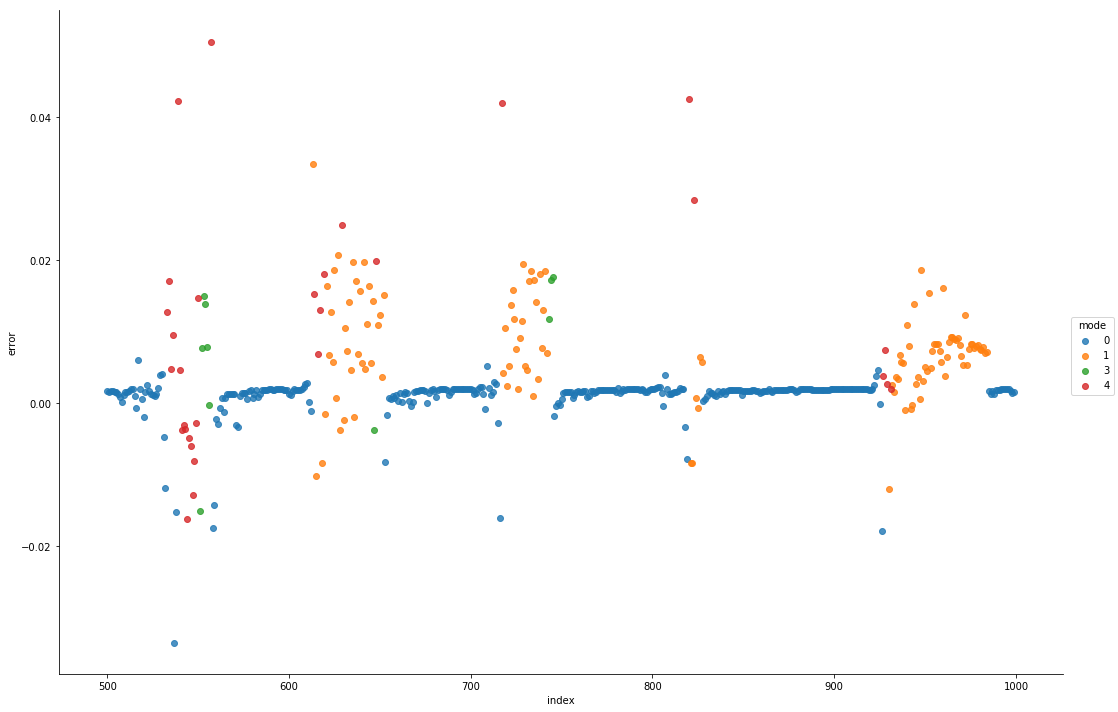

In [217]:
sns.lmplot('index','error', data=df_s[500:1000], hue='mode', fit_reg=False, 
           size = 10, aspect = 1.5)

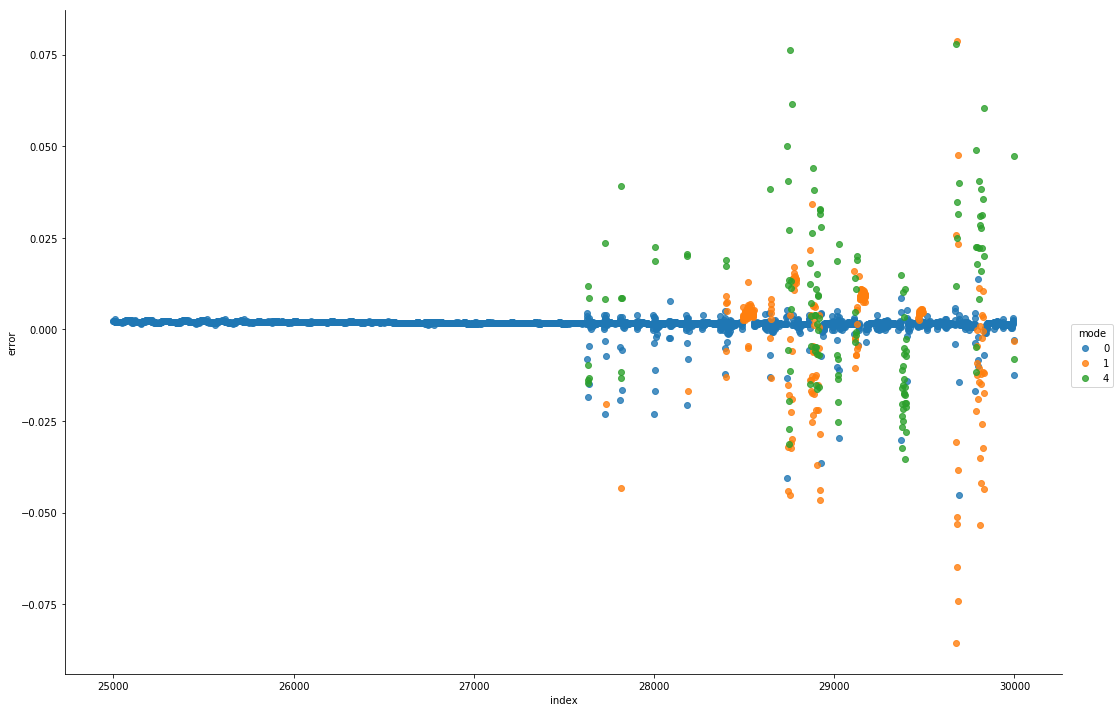

In [219]:
sns.lmplot('index','error', data=df_s[25000:30000], hue='mode', fit_reg=False, 
           size = 10, aspect = 1.5)

In [176]:
filter(df_s_trn, 'error', df_s_trn['error'].max())

,pred,target,error,mape,mode,trn_test
1716564,0.638154,0.046026,0.592128,12.865033,0,Trn


In [142]:
idx_list['trn_idx'].shape

(1759804,)

In [105]:
df_l = pd.concat([df_l_trn, df_l_test])

In [112]:
df_s['mode'].value_counts()

0    1659376
5     153422
2      56079
4      49452
1      36237
3        772
Name: mode, dtype: int64

In [113]:
1659376 / len(df_s)

0.8486389565384603

In [128]:
df_s.loc[df_s['mode'] == 1].mean()

pred      0.018904
target    0.017830
error     0.001075
mape           inf
mode      1.000000
dtype: float64

In [124]:
np.sum(df_s['target'] < 1e-3) / len(df_s)

0.92597443511045152

In [125]:
np.sum(df_s['target'] < 1e-4) / len(df_s)

0.8701129932523175

In [126]:
np.sum(df_s['target'] < 1e-5) / len(df_s)

0.8337755416199143

In [106]:
np.sum(df_s['target'] < 1e-2) / len(df_s)

0.95497607063331247

In [108]:
np.sum(df_s['target'] < 1e-2)

1867301

In [109]:
np.sum(df_l['target'] < 1e-2)

1913081

In [110]:
np.sum(df_l['target'] < 1e-2) / len(df_l)

0.97838890258359423

In [ ]:
error_per_mode(pred_s, trn['target_vars'][:,0], trn['int_vars'])

In [115]:
trn['float_vars'][:10]

array([[  4.68396433e-01,   5.71315136e-01,   2.74678856e-03, ...,
          3.48314607e-01,  -1.49723886e-12,   0.00000000e+00],
       [  6.10918559e-01,   5.61412601e-01,   7.21007586e-03, ...,
          4.60674157e-01,  -8.65054074e-13,   0.00000000e+00],
       [  4.81863165e-01,   5.04818726e-01,   4.99623090e-03, ...,
          3.25842697e-01,   5.21361552e-03,   0.00000000e+00],
       ..., 
       [  4.82895590e-01,   5.89454975e-01,   4.15300190e-03, ...,
          3.25842697e-01,  -9.06410283e-14,   0.00000000e+00],
       [  4.96528753e-01,   4.09098259e-01,   4.47763354e-03, ...,
          1.00000000e+00,   8.94873489e-13,   0.00000000e+00],
       [  4.71805168e-01,   5.54987297e-01,   6.50000751e-03, ...,
          2.35955056e-01,   3.92753827e-13,   0.00000000e+00]])

In [117]:
df_s.to_csv('Lsens.csv', index=False)
df_l.to_csv('Llat.csv', index=False)

In [293]:
np.savez('pred', pred=pred_test)

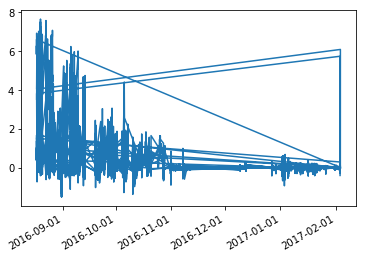

In [254]:
fig, ax = plt.subplots(1)
fig.autofmt_xdate()
plt.plot(date_test, test_targets[:,0,1])
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)

(array([ 736462.95833333,  736463.08333333,  736463.20833333,
         736463.33333333,  736463.45833333,  736463.58333333,
         736463.70833333,  736463.83333333,  736463.95833333]),
 <a list of 9 Text xticklabel objects>)

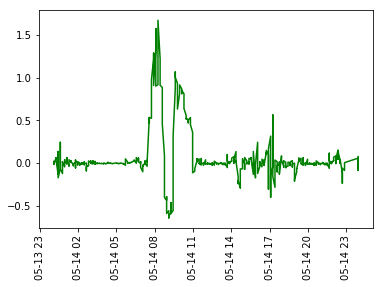

In [60]:
plt.plot(datetest, test_targets[:, 0, 1], color='g')
plt.xticks(rotation=90)
# plt.locator_params(axis='x',numticks=1)

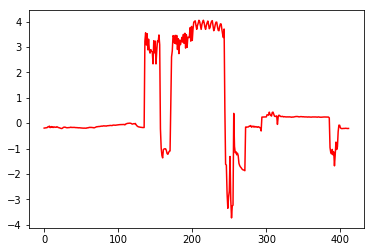

In [43]:
plt.plot(np.arange(len(pred_test)), pred_test[:, 0, 0], color='r')

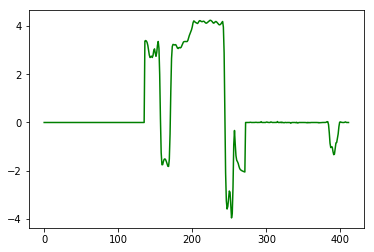

In [44]:
plt.plot(np.arange(len(pred_test)), test_targets[:, 0, 0], color='g')

In [261]:
idu_test[-10:]

[33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0]

In [288]:
def plot_range(pred, target, date, idu_data, target_variable, loss_name, idu_num_list):    
    if target_variable == 's':
        target_col = 0
    elif target_variable == 'l':
        target_col = 1
    
#     if idu_num_list:        
#         idu_data = [x for x in idu_data if x in idu_num_list]
    date = np.array(date)    
    idu_data = np.array(idu_data)
    
    pred = pred[:,0,target_col]
    target = target[:, 0, target_col]
    #         date = date[range_value]
#         pred = pred[range_value, 0, target_col]
#         target = target[range_value, 0, target_col]
#         idu_data = idu_data[[range_value]]
    
    
    if loss_name == 'rmse':
        loss = pred - target        
#         print(idu_num, 'mean', np.sqrt(np.mean(np.square(loss_idu))), 'std', np.std(np.mean(np.square(loss_idu))))
    elif loss_name == 'mae':
        loss = np.abs(pred - target)    
#         print(idu_num, 'mean', np.mean(loss_idu), 'std', np.std(loss_idu))
    
    fig, ax_list = plt.subplots(len(set(idu_num_list)), sharey=True, figsize=(10,10))
    
    fig.autofmt_xdate()    
    xfmt = mdates.DateFormatter('%Y-%m-%d-%H-%M-%S')
    
    for ax, idu_num in zip(ax_list, idu_num_list):
        mask = idu_data == idu_num
        date_idu = date[mask]
        pred_idu = pred[mask]
        target_idu = target[mask]       
        loss_idu = loss[mask]
        ax.xaxis.set_major_formatter(xfmt)
        ax.plot(date_idu, pred_idu, c='r', label='prediction_{}'.format(idu_num))
        ax.plot(date_idu, target_idu, c='b', label='true')            
        if loss_name == 'rmse':
            print(idu_num, 'mean', np.sqrt(np.mean(np.square(loss_idu))), 'std', np.std(loss_idu))
        elif loss_name == 'mae':
            print(idu_num, 'mean', np.mean(loss_idu), 'std', np.std(loss_idu))
        
#         return date_idu, target_idu, pred_idu
#         ax.plot(date_idu, loss_idu[:,target_col], color='b', label=loss_name)
#         plt.legend()

21 mean 0.165983 std 0.198504
24 mean 0.128837 std 0.206472
27 mean 0.272042 std 0.382603
30 mean 0.176295 std 0.252888


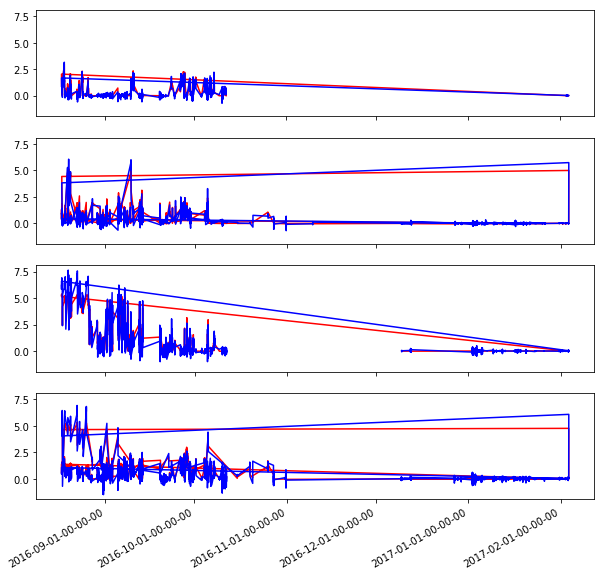

In [294]:
plot_range(pred_test, test_targets, date_test, idu_test, 'l', 'mae', [21, 24, 27, 30]) 

21 mean 0.127258 std 0.167565
24 mean 0.282335 std 0.282343
27 mean 0.249925 std 0.32027
30 mean 0.293149 std 0.321938


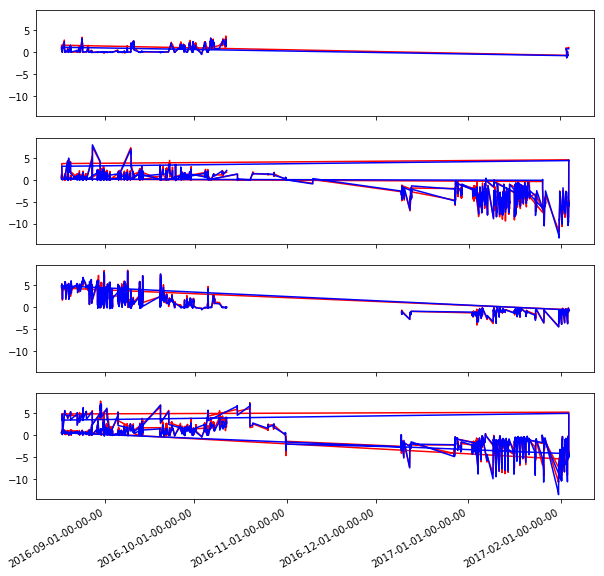

In [295]:
plot_range(pred_test, test_targets, date_test, idu_test, 's', 'mae', [21, 24, 27, 30]) 

/home/dasandata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 412 but corresponding boolean dimension is 407
/home/dasandata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 412 but corresponding boolean dimension is 407
/home/dasandata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 412 but corresponding boolean dimension is 407


0 mean 0.0280681 std 0.0376916
1 mean 0.148103 std 0.161935
2 mean 0.0745975 std 0.0679508
3 mean 0.0643009 std 0.0857418


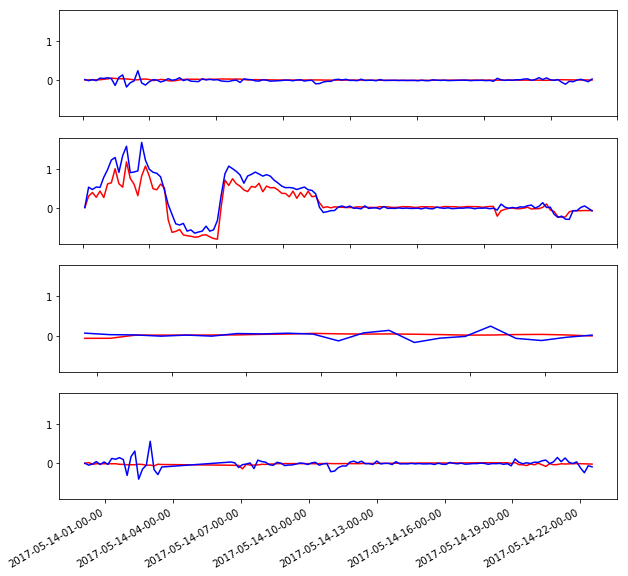

In [218]:
plot_range(pred_test, test_targets, date_test, idu_test, np.arange(200, 252), 'l', 'mae')

# plot_range(pred_test, test_targets, np.arange(150, 300), 's', 'mae')

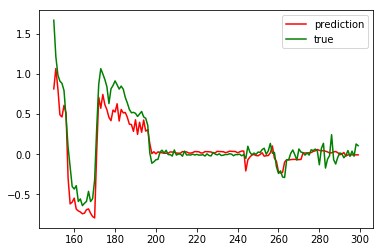

In [37]:
plot_range(pred, test_targets, np.arange(150, 300), 'l')

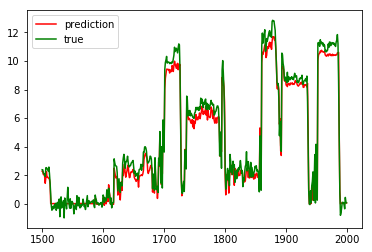

In [34]:
plot_range(pred_trn, trn_targets, np.arange(1500, 2000), 'l')

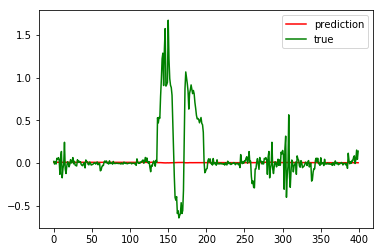

In [140]:
plot_range(pred, test_targets, np.arange(0, 400), 'l')

In [153]:
def mape_loss(pred, target, threshold, target_variable):
    if target_variable == 's':
        target_col = 0
    elif target_variable == 'l':
        target_col = 1
    target = target[:,:,target_col]
    pred = pred[:,:,target_col]
    mask = np.abs(target) > threshold    
    target = target[mask]
    pred = pred[mask]
    loss = np.mean(np.abs(pred - target) / np.abs(target))
    return loss

In [155]:
mape_loss(pred, test_targets, 3, 's'), mape_loss(pred, test_targets, 3, 'l')

/home/dasandata/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dasandata/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(0.33211359, nan)

In [169]:
for threshold in [0.5, 1.0, 2.0, 3.0, 4.0, 5.0]:
    l_loss = mape_loss(pred, test_targets, threshold, 'l')
    s_loss = mape_loss(pred, test_targets, threshold, 's')
    print('threshold: {} l loss: {}, s loss {}'.format(threshold, l_loss, s_loss))    

threshold: 1.0 l loss: 0.9975835084915161, s loss 0.274338960647583
threshold: 2.0 l loss: nan, s loss 0.31042203307151794
threshold: 3.0 l loss: nan, s loss 0.3321135938167572
threshold: 4.0 l loss: nan, s loss 0.355171799659729
threshold: 5.0 l loss: nan, s loss nan


/home/dasandata/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dasandata/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
